# Kohonen SOM on PhotoZ

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2022 04 16

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# pip install minisom

In [3]:
%matplotlib inline
import numpy as np
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from scipy.special import erfc
import pandas as pd
import seaborn as sns 
import itertools
sns.set_style("white")
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
sns.set_palette(sns.color_palette(["#9b59b6", "#95a5a6", 
                                   "#e74c3c", "#3498db", 
                                   "#34495e", "#2ecc71"]))

In [4]:
from minisom import MiniSom

In [5]:
# Set up some plotting defaults:

params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.left': True,
          'figure.figsize': [18, 10],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

In [6]:
df =pd.read_csv("mock_lsst.csv",index_col=0)

In [7]:
df

,m_obs_u,m_obs_g,m_obs_r,m_obs_i,m_obs_z,m_obs_y,m_obs_err_u,m_obs_err_g,m_obs_err_r,m_obs_err_i,m_obs_err_z,m_obs_err_y,redshifts,types,typenames
0,24.121253,23.682399,22.732664,21.760612,21.387662,21.167022,0.061651,0.067226,0.072345,0.067425,0.066002,0.071466,0.754783,1,Spiral 1
1,24.368534,23.799042,23.225134,22.826073,22.916760,22.842173,0.113034,0.109405,0.109510,0.112609,0.112472,0.108207,0.202635,4,Starburst 2
2,25.134148,25.080284,23.815267,23.253687,23.199807,22.886999,0.168432,0.174367,0.185373,0.165084,0.172020,0.168341,0.390223,2,Spiral 2
3,20.375814,19.652910,18.778945,18.453302,18.225431,18.115650,0.004410,0.004682,0.004808,0.004963,0.004778,0.005136,0.361396,2,Spiral 2
4,23.973614,23.612861,23.147131,22.698004,22.688277,22.586633,0.088914,0.090791,0.084437,0.088501,0.081487,0.098120,0.215496,4,Starburst 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,26.165706,24.093350,22.500488,21.341332,20.920425,20.642209,0.064930,0.059484,0.063189,0.062550,0.059036,0.060524,0.665550,0,Elliptical 1
19996,22.508140,22.175246,21.511871,21.162974,21.139776,21.040131,0.025340,0.027322,0.025385,0.027509,0.027004,0.026646,0.461514,3,Starburst 1
19997,27.172635,25.166559,23.488856,22.237610,21.743397,21.525413,0.131675,0.142764,0.132426,0.135734,0.131553,0.131691,0.745137,0,Elliptical 1
19998,23.138626,22.859163,22.530698,22.431895,22.040158,21.782366,0.064695,0.068356,0.059287,0.066218,0.059495,0.060966,1.242486,4,Starburst 2


In [8]:
target=df["types"].values

In [9]:
target_numbers = np.unique(target)
target_numbers

array([0, 1, 2, 3, 4, 5, 6, 7])

In [10]:
label_names=np.unique(df["typenames"].values)
label_names

array(['Elliptical 1', 'Spiral 1', 'Spiral 2', 'Starburst 1',
       'Starburst 2', 'Starburst 3', 'Starburst 4', 'Starburst 5'],
      dtype=object)

In [11]:
nt=len(target_numbers)

In [12]:
df["u-g"] = df["m_obs_u"]-df["m_obs_g"]
df["g-r"] = df["m_obs_g"]-df["m_obs_r"]
df["r-i"] = df["m_obs_r"]-df["m_obs_i"]
df["i-z"] = df["m_obs_i"]-df["m_obs_z"]
df["z-y"] = df["m_obs_z"]-df["m_obs_y"]

In [13]:
data=df[ ["u-g","g-r","r-i","i-z","z-y"] ]

In [14]:
data 

,u-g,g-r,r-i,i-z,z-y
0,0.438855,0.949735,0.972051,0.372950,0.220640
1,0.569492,0.573908,0.399062,-0.090688,0.074587
2,0.053865,1.265017,0.561580,0.053880,0.312808
3,0.722904,0.873965,0.325644,0.227871,0.109781
4,0.360754,0.465730,0.449127,0.009727,0.101644
...,...,...,...,...,...
19995,2.072356,1.592862,1.159156,0.420907,0.278215
19996,0.332893,0.663376,0.348897,0.023197,0.099645
19997,2.006076,1.677703,1.251245,0.494214,0.217984
19998,0.279464,0.328465,0.098802,0.391737,0.257792


In [15]:
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

In [16]:
data = data.values

In [17]:
# Initialization and training
n_neurons = 20
m_neurons = 20
som = MiniSom(n_neurons, m_neurons, data.shape[1], sigma=1.5, learning_rate=.5, 
              neighborhood_function='gaussian', random_seed=0)

som.pca_weights_init(data)
som.train(data, 1000, verbose=True)  # random training

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.539769681217201


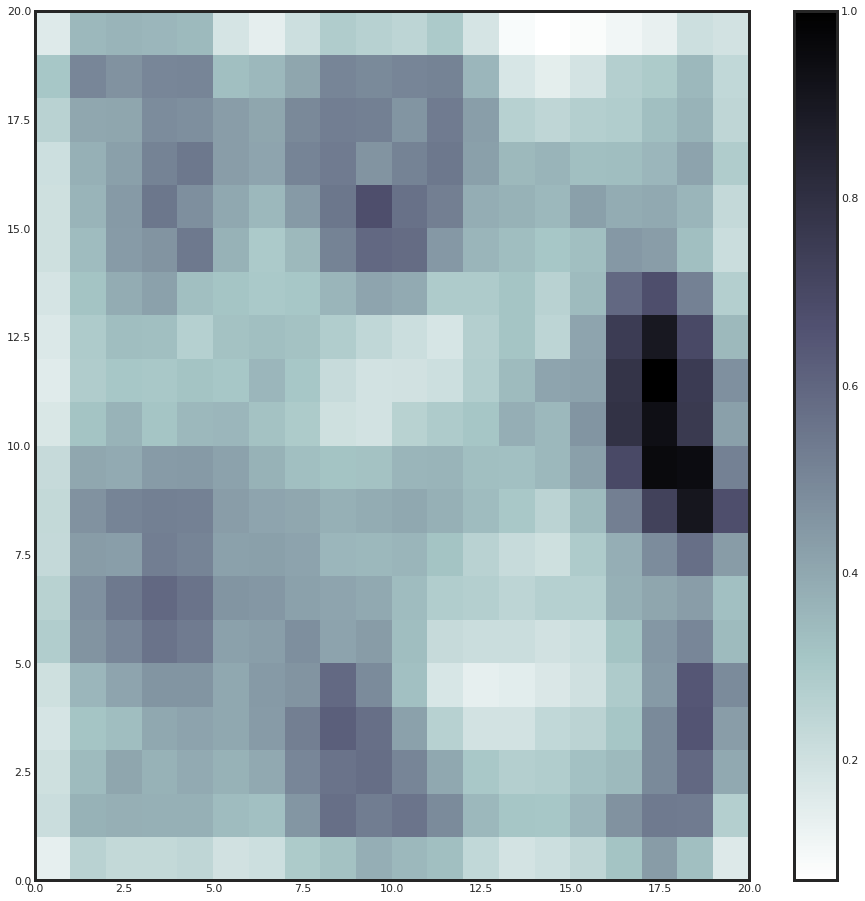

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 16))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

To visualize the result of the training we can plot the distance map (U-Matrix) using a pseudocolor where the neurons of the maps are displayed as an array of cells and the color represents the (weights) distance from the neighbour neurons. On top of the pseudo color we can add markers that repesent the samples mapped in the specific cells:

In [19]:
cols = sns.color_palette("hls", nt)

In [20]:
cols

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.7612000000000001, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5012000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.43879999999999986, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.6987999999999996)]

In [21]:
cmap = plt.cm.get_cmap('PiYG', 8)    # 11 discrete colors

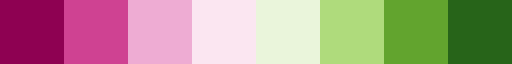

In [22]:
cmap

In [23]:
cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

In [ ]:
#15 Training inputs for RGBcolors
colors15 = [[0., 0., 0.],
      [0., 0., 1.],
      [0., 0., 0.5],
      [0.125, 0.529, 1.0],
      [0.33, 0.4, 0.67],
      [0.6, 0.5, 1.0],
      [0., 1., 0.],
      [1., 0., 0.],
      [0., 1., 1.],
      [1., 0., 1.],
      [1., 1., 0.],
      [1., 1., 1.],
      [.33, .33, .33],
      [.5, .5, .5],
      [.66, .66, .66]]

In [ ]:
color_names15 = \
    ['black', 'blue', 'darkblue', 'skyblue',
     'greyblue', 'lilac', 'green', 'red',
     'cyan', 'violet', 'yellow', 'white',
     'darkgrey', 'mediumgrey', 'lightgrey']

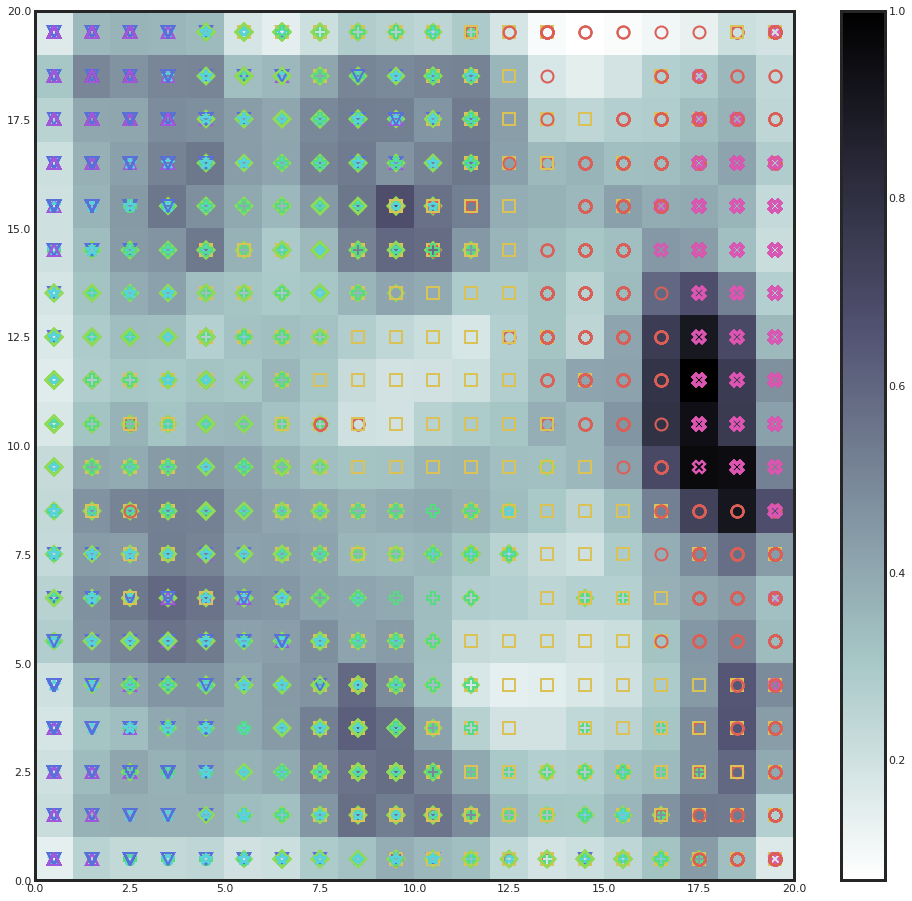

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(17, 16))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label


markers = ['o', 's', 'D', 'P', '*','v','^' ,'X' ]
#colors = ['C0', 'C1', 'C2','C3','C4','C5','C6','C7']
colors = cols

for cnt, xx in enumerate(data):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[target[cnt]-1], markerfacecolor='None',
             markeredgecolor=colors[target[cnt]-1], markersize=12, markeredgewidth=2)

plt.show()

To have an overview of how the samples are distributed across the map a scatter chart can be used where each dot represents the coordinates of the winning neuron. A random offset is added to avoid overlaps between points within the same cell.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

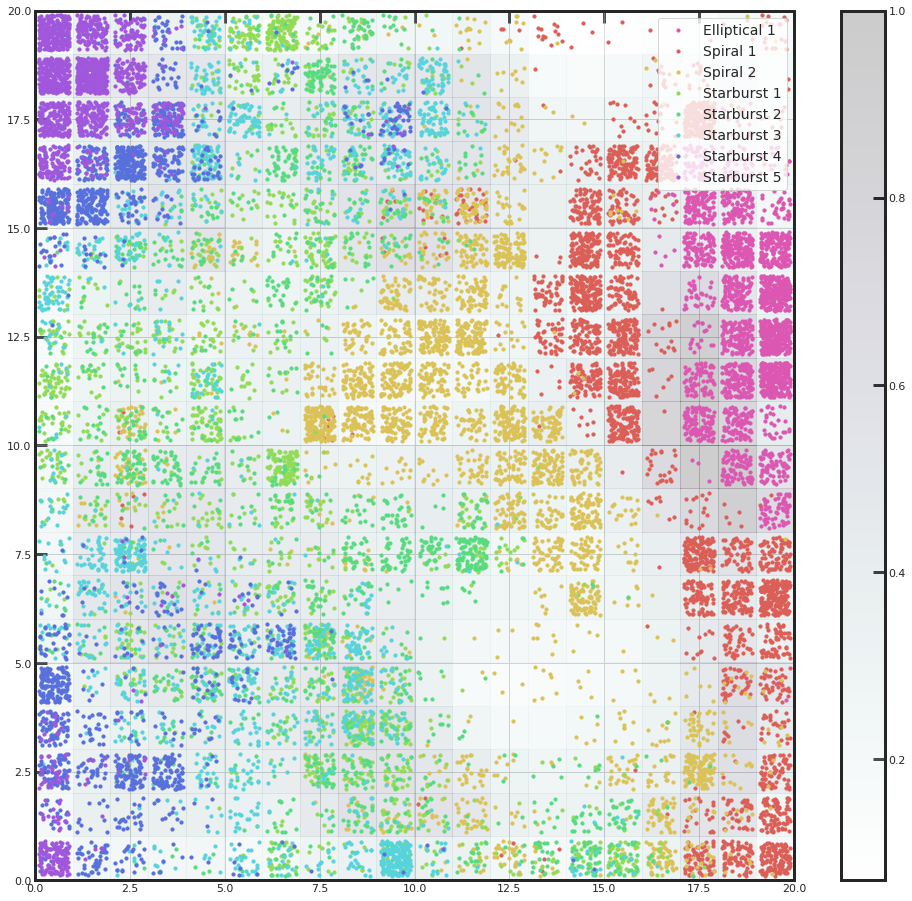

In [25]:
w_x, w_y = zip(*[som.winner(d) for d in data])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(17, 16))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

for c in np.unique(target):
    idx_target = target==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=10, c=colors[c-1], label=label_names[c])
plt.legend(loc='upper right')
plt.grid()
plt.show()

When dealing with a supervised problem, one can visualize the proportion of samples per class falling in a specific neuron using a pie chart per neuron:

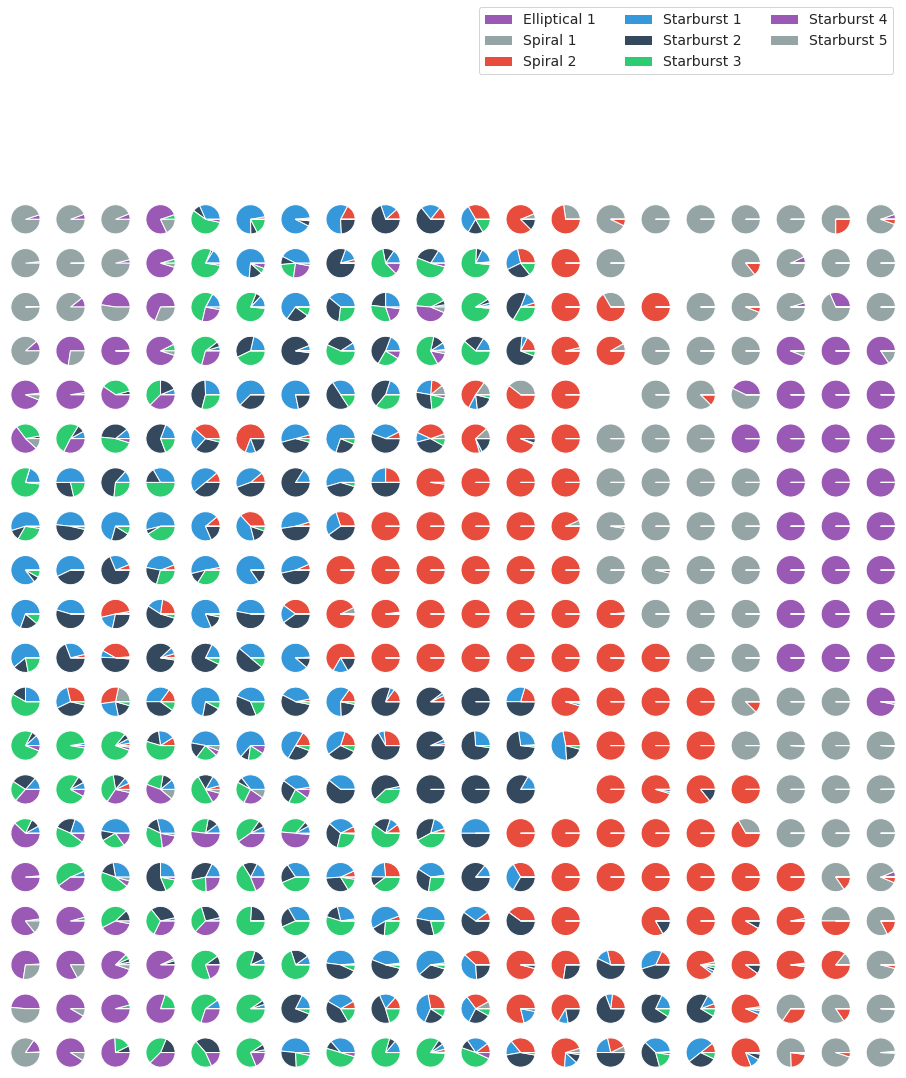

In [26]:
import matplotlib.gridspec as gridspec

labels_map = som.labels_map(data, [label_names[t] for t in target])

fig = plt.figure(figsize=(16, 16))
the_grid = gridspec.GridSpec(n_neurons, m_neurons, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names]
    plt.subplot(the_grid[n_neurons-1-position[1],
                         position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names, bbox_to_anchor=(3.5, 6.5), ncol=3)
plt.show()

To have an idea of which neurons of the map are activated more often we can create another pseudocolor plot that reflects the activation frequencies:

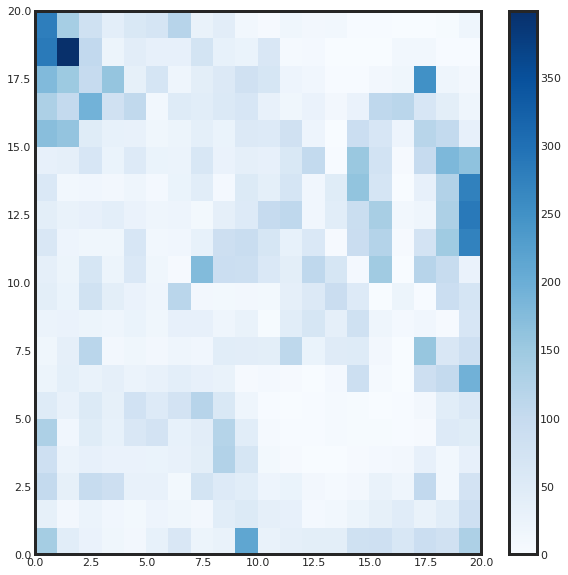

In [27]:
plt.figure(figsize=(10, 10))
frequencies = som.activation_response(data)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.show()

In [ ]:
som = MiniSom(n_neurons, m_neurons, data.shape[1], sigma=1.5, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=10)

max_iter = 1000
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(data))
    som.update(data[rand_i], som.winner(data[rand_i]), i, max_iter)
    q_error.append(som.quantization_error(data))
    t_error.append(som.topographic_error(data))

plt.figure(figsize=(12,8))
plt.plot(np.arange(max_iter), q_error, label='quantization error')
plt.plot(np.arange(max_iter), t_error, label='topographic error')
plt.ylabel('error')
plt.xlabel('iteration index')
plt.legend()
plt.show()